In [118]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

In [119]:
client = InfluxDBClient(host='140.112.42.160', port=23234, database='test_2')

In [120]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [121]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

Ground Truth

In [122]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']
BS_24hr_8am = np.zeros((len(date),), dtype = int)
BS_24hr_8am_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12pm = np.zeros((len(date),), dtype = int)
BS_24hr_12pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_4pm = np.zeros((len(date),), dtype = int)
BS_24hr_4pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_8pm = np.zeros((len(date),), dtype = int)
BS_24hr_8pm_tran = np.zeros((len(date),), dtype = int)
BS_24hr_12am = np.zeros((len(date),), dtype = int)
BS_24hr_12am_tran = np.zeros((len(date),), dtype = int)
BS_24hr_4am = np.zeros((len(date),), dtype = int)
BS_24hr_4am_tran = np.zeros((len(date),), dtype = int)

In [123]:
def get_server_ip_bs(d1, d2, t1, t2, loc, lang=None):
    st = f'2019-{d1}T{t1}:00:00Z' 
    et = f'2019-{d2}T{t2}:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    BS, BS_t = get_edge_num(result)
    return len(BS), BS_t


In [124]:
#24hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-us')
    BS_24hr_12am[d] = num
    BS_24hr_12am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "04", "04", 'west-us')
    BS_24hr_4am[d] = num
    BS_24hr_4am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "08", "08", 'west-us')
    BS_24hr_8am[d] = num
    BS_24hr_8am_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "12", "12", 'west-us')
    BS_24hr_12pm[d] = num
    BS_24hr_12pm_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "16", "16", 'west-us')
    BS_24hr_4pm[d] = num
    BS_24hr_4pm_tran[d] = tran
    num, tran = get_server_ip_bs(date1, date2, "20", "20", 'west-us')
    BS_24hr_8pm[d] = num
    BS_24hr_8pm_tran[d] = tran
    


CJS Model -  Interval : 24hr, Duration : 1hr

timing : 12am, 4am, 8am, 12pm, 4pm, 8pm

In [14]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1 = ["00:00:00", "04:00:00", "08:00:00", "12:00:00", "16:00:00", "20:00:00"]
time_2 = ["01:00:00", "05:00:00", "09:00:00", "13:00:00", "17:00:00", "21:00:00"]

In [15]:
estimate_N_24hr = [np.zeros((len(date))) for i in range(6)]
C_tran_24hr = [np.zeros((len(date)), dtype = int) for i in range(6)]

# estimate_N_24hr_12am = np.zeros((len(date)))
# C_tran_24hr_12am = np.zeros((len(date)), dtype = int)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


In [16]:
def get_server_ip_sampling(date, t1, t2, idx, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((idx,), dtype = int)
    marked_sum = 0
    if idx > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[idx, :idx] = last_rec[::-1]
        
    m_t[idx] = marked_sum
    u_t[idx] = len(C)-marked_sum
    n_t[idx] = len(C)
    record_server_table.append(C)
    C_tran[idx] = C_t

In [17]:
for index in range(len(time_1)):
    C_tran = np.zeros((len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((len(date), len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1[index], time_2[index], j, 'west-us')

    R_t, Z_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
    for d, _ in enumerate(date):
        R_t[d] = np.sum(last_capture_table[(d+1):len(date), d])

    for d in range(len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_24hr[index] = N_t
    C_tran_24hr[index] = C_tran
    print(estimate_N_24hr[index])
    # print(C_tran_24hr_12am)

[  0.          73.          74.89119569 108.54208145  87.
 110.25        65.31451613  50.          50.          50.
  50.          50.          50.        ]
[ 0.         52.94117647 60.         69.15254237 85.87402985 77.
 78.71377368 78.00999616 76.         76.         76.         89.81818182
 57.        ]
[  0.         118.62745098 118.         122.06896552 127.412
 128.42913817 126.         126.         126.         126.54545455
 122.37755102 108.47368421 103.        ]
[  0.         125.         125.99206349 126.95861592 126.15740741
 126.         126.         126.         128.0814256  126.
 126.         116.97752809 104.        ]
[  0.         124.64516129 124.         127.91080354 124.
 126.4685571  127.95181406 124.         127.91080354 124.44186047
 126.87120338 124.24195122 100.        ]
[  0.          50.          50.          50.         123.52941176
 109.2745098   73.          73.          73.          73.
  73.          74.97297297  50.        ]


Visualization for Q2-1

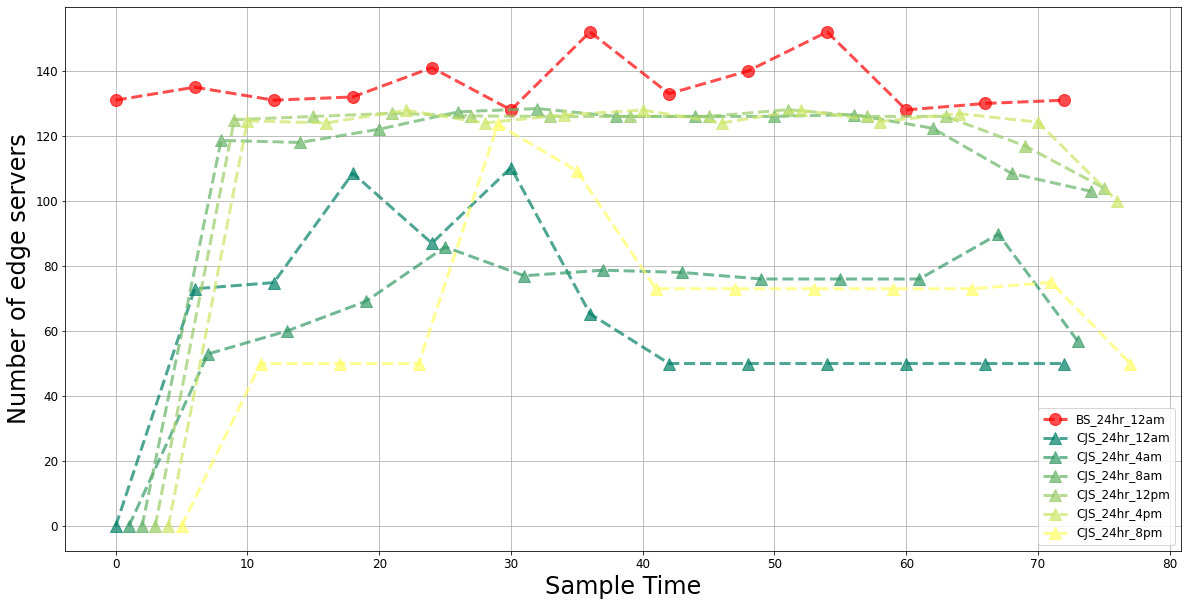

In [24]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis1 = [6*d for d in range(13)]
x_axis2 = [6*d+1 for d in range(13)]
x_axis3 = [6*d+2 for d in range(13)]
x_axis4 = [6*d+3 for d in range(13)]
x_axis5 = [6*d+4 for d in range(13)]
x_axis6 = [6*d+5 for d in range(13)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.autumn(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis2, BS_24hr_4am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_24hr_4am', alpha=0.7)
# plt.plot(x_axis3, BS_24hr_8am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[2]), label='BS_24hr_8am', alpha=0.7)
# plt.plot(x_axis4, BS_24hr_12pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[3]), label='BS_24hr_12pm', alpha=0.7)
# plt.plot(x_axis5, BS_24hr_4pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[4]), label='BS_24hr_4pm', alpha=0.7)
# plt.plot(x_axis6, BS_24hr_8pm[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[5]), label='BS_24hr_8pm', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_24hr[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_24hr_4am', alpha=0.7)
plt.plot(x_axis3, estimate_N_24hr[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_24hr_8am', alpha=0.7)
plt.plot(x_axis4, estimate_N_24hr[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_24hr_12pm', alpha=0.7)
plt.plot(x_axis5, estimate_N_24hr[4], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[4]), label='CJS_24hr_4pm', alpha=0.7)
plt.plot(x_axis6, estimate_N_24hr[5], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[5]), label='CJS_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig("Q2-1.png")
plt.show()

CJS Model -  Interval : 8hr, Duration : 1hr

timing : 

<12am, 8am, 4pm>

<2am, 10am, 6pm>

<4am, 12pm, 8pm>

<6am, 2pm, 10pm>

In [32]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1_1 = ["00:00:00", "02:00:00", "04:00:00", "06:00:00"]
time_1_2 = ["01:00:00", "03:00:00", "05:00:00", "07:00:00"]
time_2_1 = ["08:00:00", "10:00:00", "12:00:00", "14:00:00"]
time_2_2 = ["09:00:00", "11:00:00", "13:00:00", "15:00:00"]
time_3_1 = ["16:00:00", "18:00:00", "20:00:00", "22:00:00"]
time_3_2 = ["17:00:00", "19:00:00", "21:00:00", "23:00:00"]

In [33]:
estimate_N_8hr = [np.zeros(3*(len(date))) for i in range(6)]
C_tran_8hr = [np.zeros(3*(len(date)), dtype = int) for i in range(6)]

In [34]:
for index in range(len(time_1_1)):

    C_tran = np.zeros((3*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[index], time_1_2[index], 3*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[index], time_2_2[index], 3*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[index], time_3_2[index], 3*j+2, 'west-us')

    R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
    for d in range(3*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

    for d in range(3*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_8hr[index] = N_t
    C_tran_8hr[index] = C_tran
    print(estimate_N_8hr[index])

[  0.          79.          99.28378378  98.         127.63657721
 124.992      128.95040369 125.         125.         125.
 125.         128.95040369 125.         126.19047619 126.
 126.         129.46456908 129.55246914 128.984375   128.
 130.56582633 127.         127.         127.         127.
 127.         131.029604   127.         127.         127.
 127.         127.         128.49019608 126.         127.13559322
 125.11965812 118.         121.13953488 100.        ]
[  0.         103.85454545 116.52701016 113.01818182 123.73333333
 126.36986301 125.         125.         125.         125.
 125.         125.         125.         127.03252033 128.29591837
 128.         128.         128.         128.         128.
 130.48543689 130.         130.         140.96333573 127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.016      128.9047619   65.        ]
[  0.         123.57692308 125.         125.    

Visualization of Q2-2

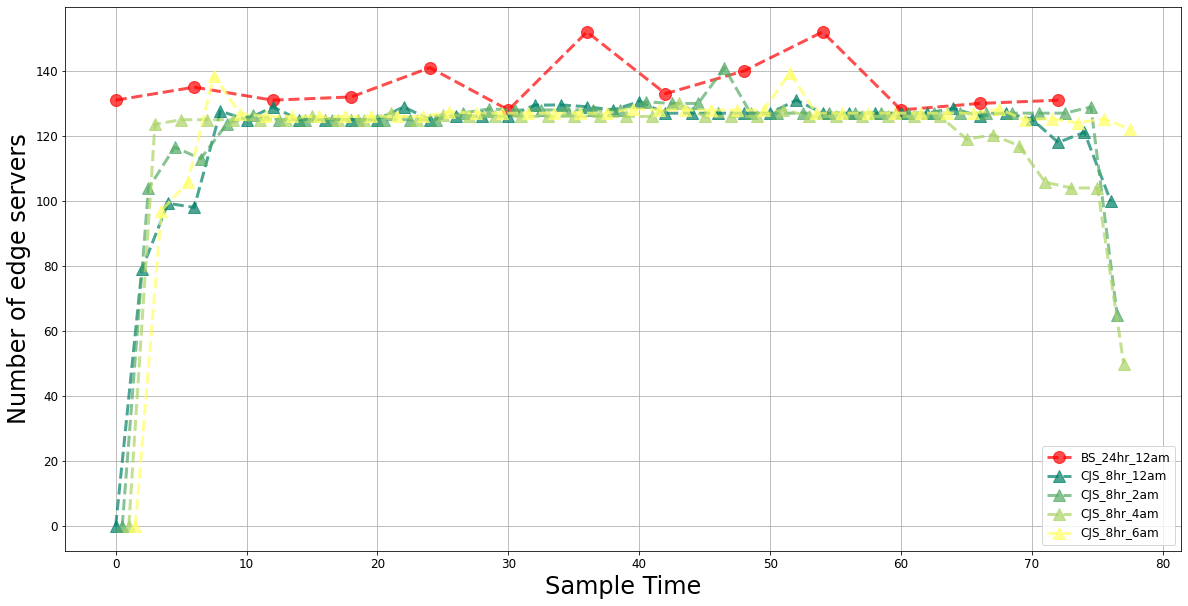

In [37]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis0 = [6*d for d in range(13)]
x_axis1 = [2*d for d in range(13*3)]
x_axis2 = [2*d+0.5 for d in range(13*3)]
x_axis3 = [2*d+1 for d in range(13*3)]
x_axis4 = [2*d+1.5 for d in range(13*3)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.autumn(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

# plt.plot(x_axis1, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_8hr_12am', alpha=0.7)
# plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_8hr_2am', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_8hr_4am', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_8hr_6am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q2-2.png')
plt.show()


CJS Model -  Interval : 4hr, Duration : 1hr

timing : 

<12am, 4am, 8am, 12pm, 4pm, 8pm>

<1am, 5am, 9am, 1pm, 5pm, 9pm>

<2am, 6am, 10am, 2pm, 6pm, 10pm>

<3am, 7am, 11am, 3pm, 7pm, 11pm>

In [41]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1_1 = ["00:00:00", "01:00:00", "02:00:00", "03:00:00"]
time_1_2 = ["01:00:00", "02:00:00", "03:00:00", "04:00:00"]
time_2_1 = ["04:00:00", "05:00:00", "06:00:00", "07:00:00"]
time_2_2 = ["05:00:00", "06:00:00", "07:00:00", "08:00:00"]
time_3_1 = ["08:00:00", "09:00:00", "10:00:00", "11:00:00"]
time_3_2 = ["09:00:00", "10:00:00", "11:00:00", "12:00:00"]
time_4_1 = ["12:00:00", "13:00:00", "14:00:00", "15:00:00"]
time_4_2 = ["13:00:00", "14:00:00", "15:00:00", "16:00:00"]
time_5_1 = ["16:00:00", "17:00:00", "18:00:00", "19:00:00"]
time_5_2 = ["17:00:00", "18:00:00", "19:00:00", "20:00:00"]
time_6_1 = ["20:00:00", "21:00:00", "22:00:00", "23:00:00"]
time_6_2 = ["21:00:00", "22:00:00", "23:00:00", "23:59:59"]

In [42]:
estimate_N_4hr = [np.zeros(6*(len(date))) for i in range(6)]
C_tran_4hr = [np.zeros(6*(len(date)), dtype = int) for i in range(6)]

In [43]:
for index in range(len(time_1_1)):
    C_tran = np.zeros((6*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[index], time_1_2[index], 6*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[index], time_2_2[index], 6*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[index], time_3_2[index], 6*j+2, 'west-us')
        get_server_ip_sampling(d, time_4_1[index], time_4_2[index], 6*j+3, 'west-us')
        get_server_ip_sampling(d, time_5_1[index], time_5_2[index], 6*j+4, 'west-us')
        get_server_ip_sampling(d, time_6_1[index], time_6_2[index], 6*j+5, 'west-us')

    R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
    for d in range(6*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

    for d in range(6*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_4hr[index] = N_t
    C_tran_4hr[index] = C_tran
    print(estimate_N_4hr[index])

[  0.          79.          79.         124.425      125.
 125.         125.         125.         127.16015406 126.
 126.         126.         129.99000384 126.         126.
 127.0079995  126.         126.         126.         126.
 126.         127.48235294 131.029604   127.         127.
 128.54878049 129.21904762 129.         129.         129.
 129.         129.         131.01757707 129.         131.60841049
 129.         131.015625   130.         130.         130.
 131.07142857 128.         128.         132.06920415 128.
 128.         128.         128.         128.         128.
 128.         129.08903226 131.029604   127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         128.49019608
 126.         126.         126.         127.13559322 125.
 125.01626016 126.32888889 124.         124.         124.84
 123.76470588 100.          50.        ]
[  0.          64.49519416  63.         124.03125    124.
 124.        

Visualization of Q2-3

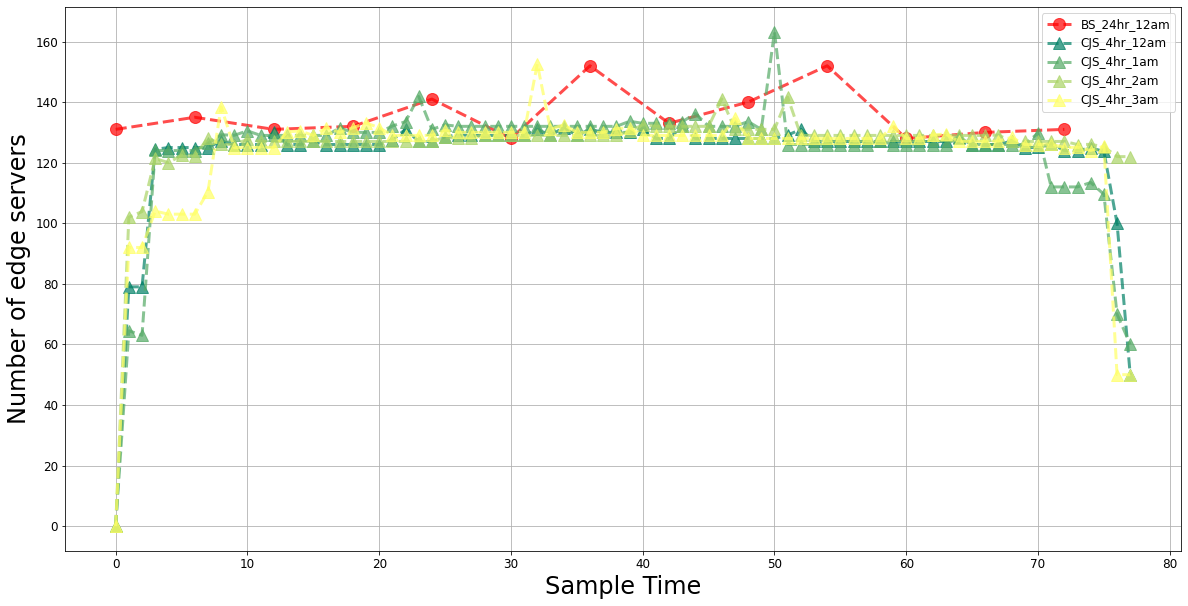

In [44]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis0 = [6*d for d in range(13)]
x_axis1 = [d for d in range(13*6)]
x_axis2 = [d+0.5 for d in range(13*6)]
x_axis3 = [d+1 for d in range(13*6)]
x_axis4 = [d+2 for d in range(13*6)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.autumn(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

# plt.plot(x_axis1, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_4hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_4hr_12am', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_4hr_1am', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_4hr_2am', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_4hr_3am', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q2-3.png')
plt.show()

Sensitivity to Duration

spacing: 4hr

durations:<60, 50, 40, 30, 20, 10, 5, 1> min

Timing Start: 12am, 1am, 2am, 3am

In [133]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1_1 = ["00:00:00", '01:00:00', '02:00:00', '03:00:00']
time_1_diff = [["01:00:00", '02:00:00', '03:00:00', '04:00:00'], ['00:50:00', '01:50:00', '02:50:00', '03:50:00'], ['00:40:00', '01:40:00', '02:40:00', '03:40:00'], ['00:30:00', '01:30:00', '02:30:00', '03:30:00'], ['00:20:00', '01:20:00', '02:20:00', '03:20:00'], ['00:10:00', '01:10:00', '02:10:00', '03:10:00'], ['00:05:00', '01:05:00', '02:05:00', '03:05:00'], ['00:01:00', '01:01:00', '02:01:00', '03:01:00']]

time_2_1 = ['04:00:00', '05:00:00', '06:00:00', '07:00:00']
time_2_diff = [['05:00:00', '06:00:00', '07:00:00', '08:00:00'], ['04:50:00', '05:50:00', '06:50:00', '07:50:00'], ['04:40:00', '05:40:00', '06:40:00', '07:40:00'], ['04:30:00', '05:30:00', '06:30:00', '07:30:00'], ['04:20:00', '05:20:00', '06:20:00', '07:20:00'], ['04:10:00', '05:10:00', '06:10:00', '07:10:00'], ['04:05:00', '05:05:00', '06:05:00', '07:05:00'], ['04:01:00', '05:01:00', '06:01:00', '07:01:00']]

time_3_1 = ['08:00:00', '09:00:00', '10:00:00', '11:00:00']
time_3_diff = [['09:00:00', '10:00:00', '11:00:00', '12:00:00'], ['08:50:00', '09:50:00', '10:50:00', '11:50:00'], ['08:40:00', '09:40:00', '10:40:00', '11:40:00'], ['08:30:00', '09:30:00', '10:30:00', '11:30:00'], ['08:20:00', '09:20:00', '10:20:00', '11:20:00'], ['08:10:00', '09:10:00', '10:10:00', '11:10:00'], ['08:05:00', '09:05:00', '10:05:00', '11:05:00'], ['08:01:00', '09:01:00', '10:01:00', '11:01:00']]

time_4_1 = ['12:00:00', '13:00:00', '14:00:00', '15:00:00']
time_4_diff = [['13:00:00', '14:00:00', '15:00:00', '16:00:00'], ['12:50:00', '13:50:00', '14:50:00', '15:50:00'], ['12:40:00', '13:40:00', '14:40:00', '15:40:00'], ['12:30:00', '13:30:00', '14:30:00', '15:30:00'], ['12:20:00', '13:20:00', '14:20:00', '15:20:00'], ['12:10:00', '13:10:00', '14:10:00', '15:10:00'], ['12:05:00', '13:05:00', '14:05:00', '15:05:00'], ['12:01:00', '13:01:00', '14:01:00', '15:01:00']]

time_5_1 = ['16:00:00', '17:00:00', '18:00:00', '19:00:00']
time_5_diff = [['17:00:00', '18:00:00', '19:00:00', '20:00:00'], ['16:50:00', '17:50:00', '18:50:00', '19:50:00'], ['16:40:00', '17:40:00', '18:40:00', '19:40:00'], ['16:30:00', '17:30:00', '18:30:00', '19:30:00'], ['16:20:00', '17:20:00', '18:20:00', '19:20:00'], ['16:10:00', '17:10:00', '18:10:00', '19:10:00'], ['16:05:00', '17:05:00', '18:05:00', '19:05:00'], ['16:01:00', '17:01:00', '18:01:00', '19:01:00']]

time_6_1 = ['20:00:00', '21:00:00', '22:00:00', '23:00:00']
time_6_diff = [['21:00:00', '22:00:00', '23:00:00', '23:59:59'], ['20:50:00', '21:50:00', '22:50:00', '23:50:00'], ['20:40:00', '21:40:00', '22:40:00', '23:40:00'], ['20:30:00', '21:30:00', '22:30:00', '23:30:00'], ['20:20:00', '21:20:00', '22:20:00', '23:20:00'], ['20:10:00', '21:10:00', '22:10:00', '23:10:00'], ['20:05:00', '21:05:00', '22:05:00', '23:05:00'], ['20:01:00', '21:01:00', '22:01:00', '23:01:00']]

# print(len(time_1_diff), len(time_2_diff), len(time_3_diff), len(time_4_diff), len(time_5_diff) ,len(time_6_diff))

Timing : 12am

In [126]:
estimate_N_4hr_diff_12am = [np.zeros(6*(len(date))) for i in range(8)]
C_tran_4hr_diff_12am = [np.zeros(6*(len(date)), dtype = int) for i in range(8)]

In [127]:
for index in range(len(time_1_diff)):
    C_tran = np.zeros((6*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[0], time_1_diff[index][0], 6*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[0], time_2_diff[index][0], 6*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[0], time_3_diff[index][0], 6*j+2, 'west-us')
        get_server_ip_sampling(d, time_4_1[0], time_4_diff[index][0], 6*j+3, 'west-us')
        get_server_ip_sampling(d, time_5_1[0], time_5_diff[index][0], 6*j+4, 'west-us')
        get_server_ip_sampling(d, time_6_1[0], time_6_diff[index][0], 6*j+5, 'west-us')

    R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
    for d in range(6*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

    for d in range(6*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_4hr_diff_12am[index] = N_t
    C_tran_4hr_diff_12am[index] = C_tran
    print(estimate_N_4hr_diff_12am[index])

[  0.          79.          79.         124.425      125.
 125.         125.         125.         127.16015406 126.
 126.         126.         129.99000384 126.         126.
 127.0079995  126.         126.         126.         126.
 126.         127.48235294 131.029604   127.         127.
 128.54878049 129.21904762 129.         129.         129.
 129.         129.         131.01757707 129.         131.60841049
 129.         131.015625   130.         130.         130.
 131.07142857 128.         128.         132.06920415 128.
 128.         128.         128.         128.         128.
 128.         129.08903226 131.029604   127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         128.49019608
 126.         126.         126.         127.13559322 125.
 125.01626016 126.32888889 124.         124.         124.84
 123.76470588 100.          50.        ]
[  0.          79.          79.         123.4375     125.34782609
 125.

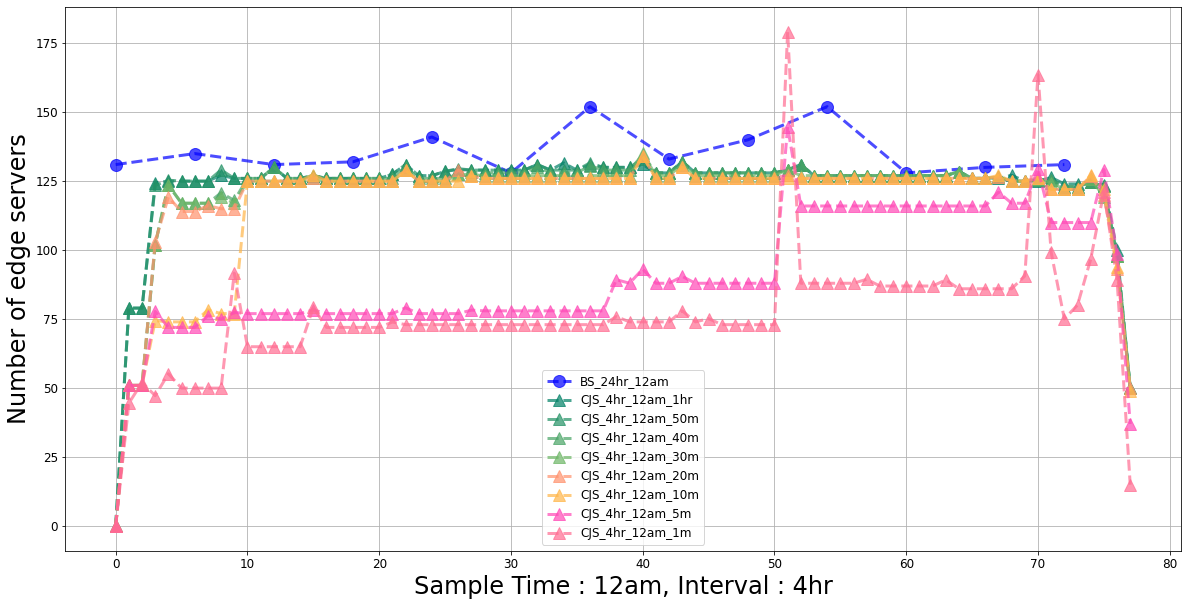

In [128]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']

x_axis0 = [6*d for d in range(13)]
x_axis1 = [d for d in range(13*6)]
x_axis2 = [d+0.5 for d in range(13*6)]
x_axis3 = [d+1 for d in range(13*6)]
x_axis4 = [d+2 for d in range(13*6)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time : 12am, Interval : 4hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis0, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_4hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_diff_12am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_4hr_12am_1hr', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_diff_12am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_4hr_12am_50m', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_diff_12am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_4hr_12am_40m', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_diff_12am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_4hr_12am_30m', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_diff_12am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_12am_20m', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_diff_12am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_12am_10m', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_diff_12am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12am_5m', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_diff_12am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_12am_1m', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-4hr-12am.png')
plt.show()

Timing 1am

In [92]:
estimate_N_4hr_diff_1am = [np.zeros(6*(len(date))) for i in range(8)]
C_tran_4hr_diff_1am = [np.zeros(6*(len(date)), dtype = int) for i in range(8)]

In [93]:
for index in range(len(time_1_diff)):
    C_tran = np.zeros((6*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[1], time_1_diff[index][1], 6*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[1], time_2_diff[index][1], 6*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[1], time_3_diff[index][1], 6*j+2, 'west-us')
        get_server_ip_sampling(d, time_4_1[1], time_4_diff[index][1], 6*j+3, 'west-us')
        get_server_ip_sampling(d, time_5_1[1], time_5_diff[index][1], 6*j+4, 'west-us')
        get_server_ip_sampling(d, time_6_1[1], time_6_diff[index][1], 6*j+5, 'west-us')

    R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
    for d in range(6*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

    for d in range(6*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_4hr_diff_1am[index] = N_t
    C_tran_4hr_diff_1am[index] = C_tran
    print(estimate_N_4hr_diff_1am[index])

[  0.          64.49519416  63.         124.03125    124.
 124.         124.         126.43137255 129.21348315 129.04918033
 130.51710812 129.         129.         129.         129.
 129.         129.         131.48076923 130.         130.
 130.         132.10348706 133.56862745 141.85810811 131.
 132.48863636 132.         132.         132.         132.
 132.         132.         132.         132.         132.
 132.         132.         132.         132.         133.67088608
 133.         133.         133.         133.51136364 136.22760477
 132.         132.         132.         133.58823529 131.
 163.18417367 126.         126.         126.         126.
 126.         126.         126.         127.26012436 126.
 126.         126.         126.         126.         128.29414741
 126.         126.         126.         126.         126.
 129.7752809  112.         112.         112.         113.45
 109.56230159  70.          60.        ]
[  0.          64.49519416  63.         124.03125    12

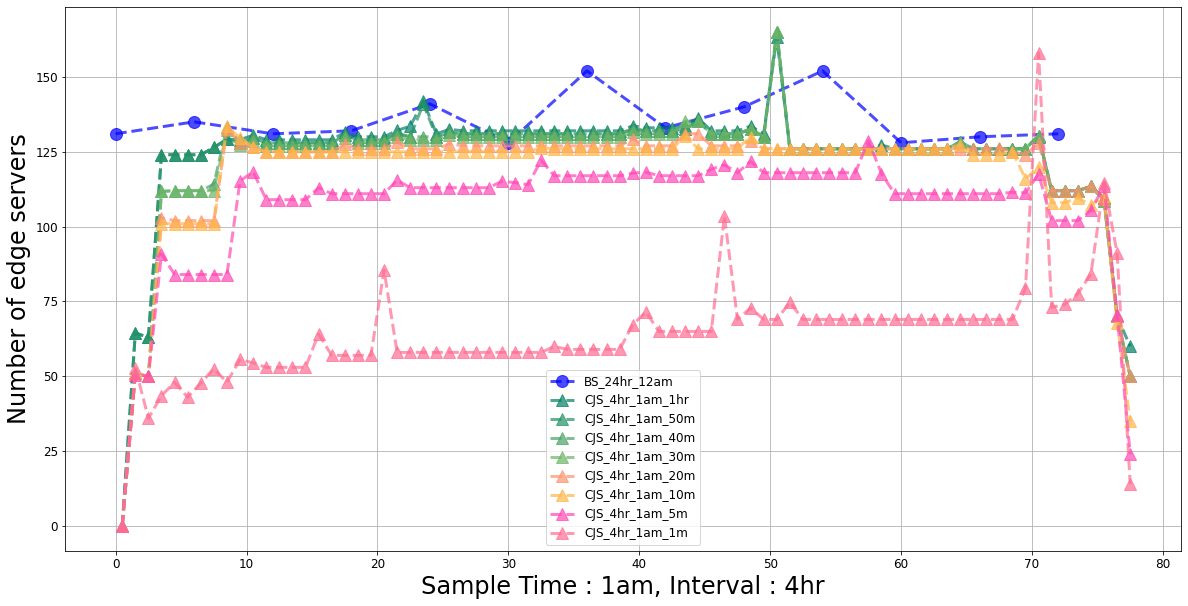

In [94]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']

x_axis0 = [6*d for d in range(13)]
x_axis1 = [d for d in range(13*6)]
x_axis2 = [d+0.5 for d in range(13*6)]
x_axis3 = [d+1 for d in range(13*6)]
x_axis4 = [d+2 for d in range(13*6)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time : 1am, Interval : 4hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis1, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_4hr_12am', alpha=0.7)

plt.plot(x_axis2, estimate_N_4hr_diff_1am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_4hr_1am_1hr', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_diff_1am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_4hr_1am_50m', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_diff_1am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_4hr_1am_40m', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_diff_1am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_4hr_1am_30m', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_diff_1am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_1am_20m', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_diff_1am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_1am_10m', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_diff_1am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_1am_5m', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_diff_1am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_1am_1m', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-4hr-1am.png')
plt.show()

Timing 2am

In [130]:
estimate_N_4hr_diff_2am = [np.zeros(6*(len(date))) for i in range(8)]
C_tran_4hr_diff_2am = [np.zeros(6*(len(date)), dtype = int) for i in range(8)]

In [131]:
for index in range(len(time_1_diff)):
    C_tran = np.zeros((6*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[2], time_1_diff[index][2], 6*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[2], time_2_diff[index][2], 6*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[2], time_3_diff[index][2], 6*j+2, 'west-us')
        get_server_ip_sampling(d, time_4_1[2], time_4_diff[index][2], 6*j+3, 'west-us')
        get_server_ip_sampling(d, time_5_1[2], time_5_diff[index][2], 6*j+4, 'west-us')
        get_server_ip_sampling(d, time_6_1[2], time_6_diff[index][2], 6*j+5, 'west-us')

    R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
    for d in range(6*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

    for d in range(6*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_4hr_diff_2am[index] = N_t
    C_tran_4hr_diff_2am[index] = C_tran
    print(estimate_N_4hr_diff_2am[index])

[  0.         102.         103.85454545 121.39285714 120.00640923
 122.45283019 122.18181818 128.11764706 126.08695652 126.
 127.7027027  127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.45977011 128.         128.         129.30612245 129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         130.41758242
 132.52427184 132.         132.         132.         132.
 132.         141.05970924 131.         131.         131.
 131.         141.64822404 129.         129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.13333333 127.         127.
 127.         127.         127.016      126.         126.04918033
 125.27030844 122.         122.        ]
[  0.         102.         103.85454545 121.39285714 120.00640923

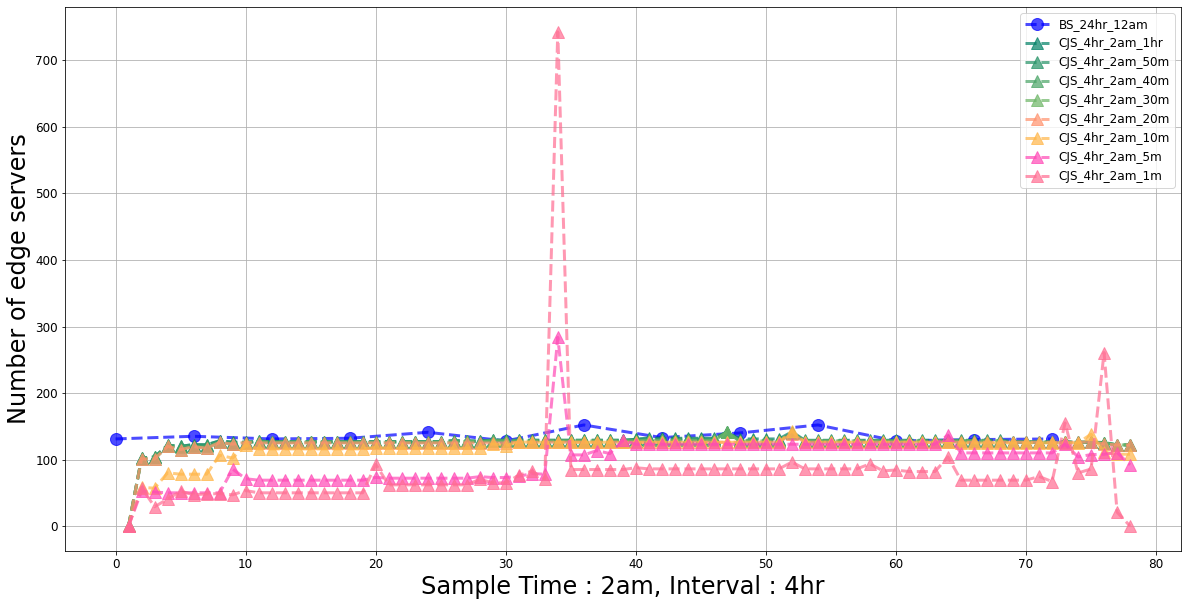

In [132]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']

x_axis0 = [6*d for d in range(13)]
x_axis1 = [d for d in range(13*6)]
x_axis2 = [d+0.5 for d in range(13*6)]
x_axis3 = [d+1 for d in range(13*6)]
x_axis4 = [d+2 for d in range(13*6)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time : 2am, Interval : 4hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis0, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_4hr_12am', alpha=0.7)

plt.plot(x_axis3, estimate_N_4hr_diff_2am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_4hr_2am_1hr', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_diff_2am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_4hr_2am_50m', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_diff_2am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_4hr_2am_40m', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_diff_2am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_4hr_2am_30m', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_diff_2am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_2am_20m', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_diff_2am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_2am_10m', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_diff_2am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_2am_5m', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_diff_2am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_2am_1m', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-4hr-2am.png')
plt.show()

Timing 3am

In [134]:
estimate_N_4hr_diff_3am = [np.zeros(6*(len(date))) for i in range(8)]
C_tran_4hr_diff_3am = [np.zeros(6*(len(date)), dtype = int) for i in range(8)]

In [135]:
for index in range(len(time_1_diff)):
    C_tran = np.zeros((6*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[3], time_1_diff[index][3], 6*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[3], time_2_diff[index][3], 6*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[3], time_3_diff[index][3], 6*j+2, 'west-us')
        get_server_ip_sampling(d, time_4_1[3], time_4_diff[index][3], 6*j+3, 'west-us')
        get_server_ip_sampling(d, time_5_1[3], time_5_diff[index][3], 6*j+4, 'west-us')
        get_server_ip_sampling(d, time_6_1[3], time_6_diff[index][3], 6*j+5, 'west-us')

    R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
    for d in range(6*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

    for d in range(6*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_4hr_diff_3am[index] = N_t
    C_tran_4hr_diff_3am[index] = C_tran
    print(estimate_N_4hr_diff_3am[index])

[  0.          92.          92.         104.01097509 103.
 103.         103.         110.35714286 138.44827586 125.
 125.         125.         125.         130.19187863 130.47945205
 129.         131.52941176 130.         131.54901961 133.10880431
 131.5586414  129.         129.         129.         129.
 130.69736842 130.         130.         130.         130.
 130.         130.         152.58530184 131.         132.53322072
 130.         130.         130.         131.25111474 131.54901961
 129.         129.         129.         129.         129.
 129.         129.         134.59841629 128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         132.06920415
 128.         128.         129.12451335 129.50980392 127.
 127.         127.         127.11403509 128.38257778 126.
 126.         126.1559633  125.         125.10619469 124.
 125.48        50.          50.        ]
[  0.          84.          84.         104.01202

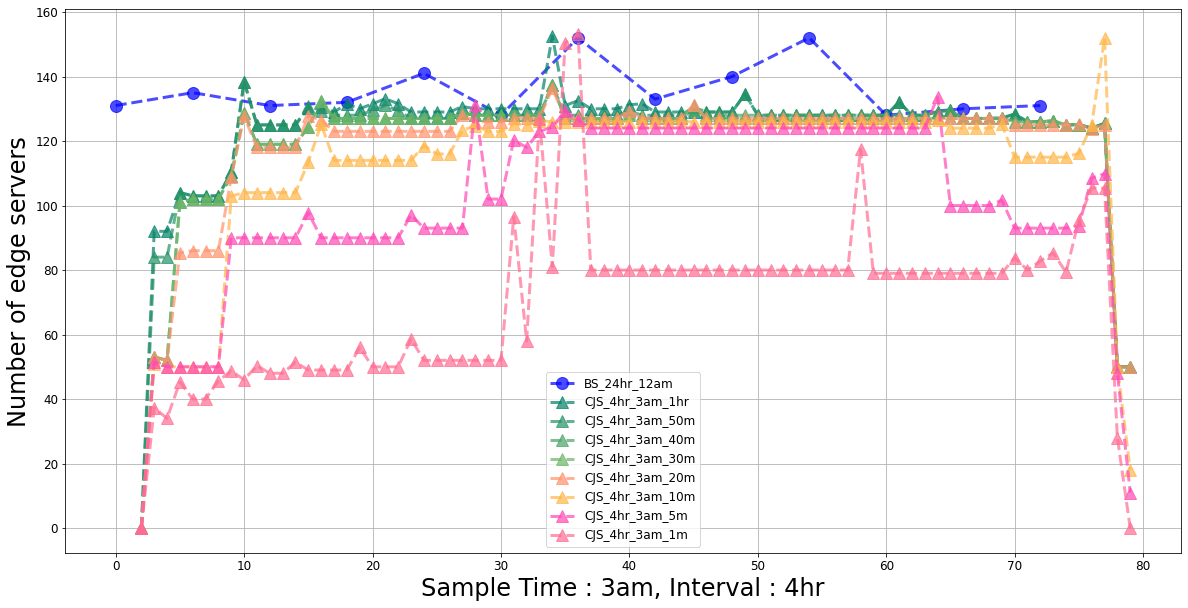

In [136]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']

x_axis0 = [6*d for d in range(13)]
x_axis1 = [d for d in range(13*6)]
x_axis2 = [d+0.5 for d in range(13*6)]
x_axis3 = [d+1 for d in range(13*6)]
x_axis4 = [d+2 for d in range(13*6)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time : 3am, Interval : 4hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis1, BS_4hr_12am[5:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_4hr_12am', alpha=0.7)

plt.plot(x_axis4, estimate_N_4hr_diff_3am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_4hr_3am_1hr', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_diff_3am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_4hr_3am_50m', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_diff_3am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_4hr_3am_40m', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_diff_3am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_4hr_3am_30m', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_diff_3am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_3am_20m', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_diff_3am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_3am_10m', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_diff_3am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_3am_5m', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_diff_3am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am_1m', alpha=0.7)


ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-4hr-3am.png')
plt.show()

Sensitivity to Duration

spacing: 8hr

durations:<60, 50, 40, 30, 20, 10, 5, 1> min

Timing Start: 12am, 2am, 4am, 6am

In [137]:
date =   ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
time_1_1 = ["00:00:00", "02:00:00", "04:00:00", "06:00:00"]
time_1_diff = [["01:00:00", "03:00:00", "05:00:00", "07:00:00"], ["00:50:00", "02:50:00", "04:50:00", "06:50:00"], ["00:40:00", "02:40:00", "04:40:00", "06:40:00"], ["00:30:00", "02:30:00", "04:30:00", "06:30:00"], ["00:20:00", "02:20:00", "04:20:00", "06:20:00"], ["00:10:00", "02:10:00", "04:10:00", "06:10:00"], ["00:05:00", "02:05:00", "04:05:00", "06:05:00"], ["00:01:00", "02:01:00", "04:01:00", "06:01:00"]]

time_2_1 = ["08:00:00", "10:00:00", "12:00:00", "14:00:00"]
time_2_diff = [["09:00:00", "11:00:00", "13:00:00", "15:00:00"], ["08:50:00", "10:50:00", "12:50:00", "14:50:00"], ["08:40:00", "10:40:00", "12:40:00", "14:40:00"], ["08:30:00", "10:30:00", "12:30:00", "14:30:00"], ["08:20:00", "10:20:00", "12:20:00", "14:20:00"], ["08:10:00", "10:10:00", "12:10:00", "14:10:00"], ["08:05:00", "10:05:00", "12:05:00", "14:05:00"], ["08:01:00", "10:01:00", "12:01:00", "14:01:00"]]

time_3_1 = ["16:00:00", "18:00:00", "20:00:00", "22:00:00"]
time_3_diff = [["17:00:00", "19:00:00", "21:00:00", "23:00:00"], ["16:50:00", "18:50:00", "20:50:00", "22:50:00"], ["16:40:00", "18:40:00", "20:40:00", "22:40:00"], ["16:30:00", "18:30:00", "20:30:00", "22:30:00"], ["16:20:00", "18:20:00", "20:20:00", "22:20:00"], ["16:10:00", "18:10:00", "20:10:00", "22:10:00"], ["16:05:00", "18:05:00", "20:05:00", "22:05:00"], ["16:01:00", "18:01:00", "20:01:00", "22:01:00"]]



# print(len(time_1_diff), len(time_2_diff), len(time_3_diff), len(time_4_diff), len(time_5_diff) ,len(time_6_diff))

Timing 12am

In [138]:
estimate_N_8hr_diff_12am = [np.zeros(3*(len(date))) for i in range(8)]
C_tran_8hr_diff_12am = [np.zeros(3*(len(date)), dtype = int) for i in range(8)]

In [139]:
for index in range(len(time_1_diff)):

    C_tran = np.zeros((3*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[0], time_1_diff[index][0], 3*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[0], time_2_diff[index][0], 3*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[0], time_3_diff[index][0], 3*j+2, 'west-us')

    R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
    for d in range(3*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

    for d in range(3*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_8hr_diff_12am[index] = N_t
    C_tran_8hr_diff_12am[index] = C_tran
    print(estimate_N_8hr_diff_12am[index])

[  0.          79.          99.28378378  98.         127.63657721
 124.992      128.95040369 125.         125.         125.
 125.         128.95040369 125.         126.19047619 126.
 126.         129.46456908 129.55246914 128.984375   128.
 130.56582633 127.         127.         127.         127.
 127.         131.029604   127.         127.         127.
 127.         127.         128.49019608 126.         127.13559322
 125.11965812 118.         121.13953488 100.        ]
[  0.          79.          99.28378378  98.         147.97244303
 124.96721311 128.95040369 125.         125.         125.
 125.         128.95040369 125.         126.5060241  126.
 126.         129.46456908 127.         129.59183673 128.
 133.53921569 127.         127.         127.         127.
 127.         131.029604   127.         127.34821429 124.
 124.         124.21621622 123.39215686 121.         121.
 121.57       118.         121.57142857  98.        ]
[  0.          50.          82.35294118  83.         125

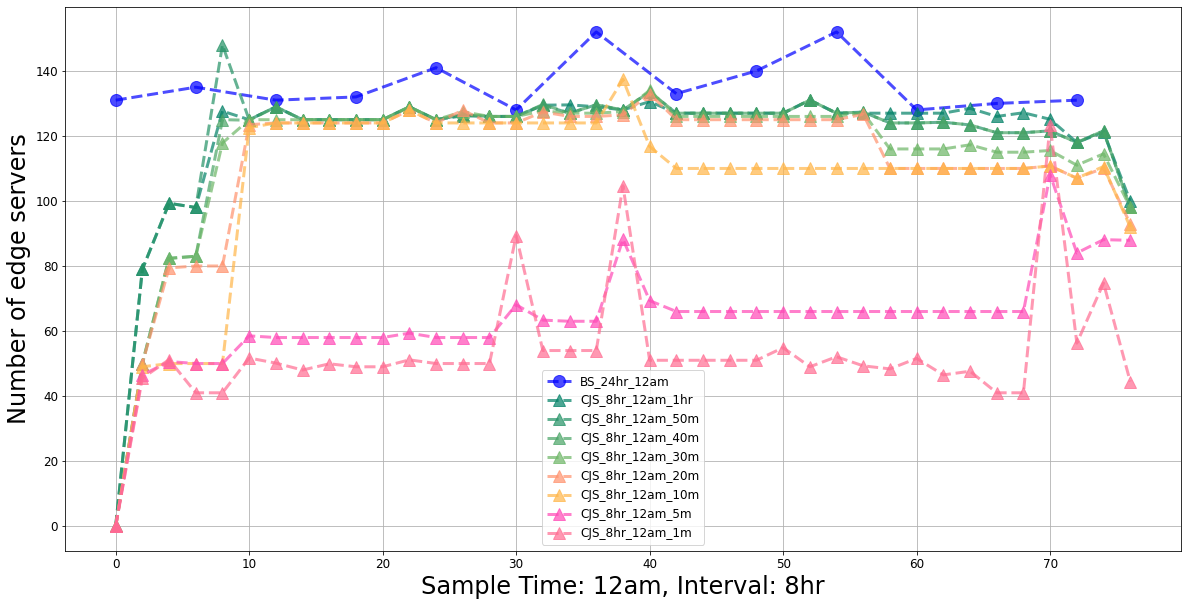

In [140]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis0 = [6*d for d in range(13)]
x_axis1 = [2*d for d in range(13*3)]
x_axis2 = [2*d+0.5 for d in range(13*3)]
x_axis3 = [2*d+1 for d in range(13*3)]
x_axis4 = [2*d+1.5 for d in range(13*3)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time: 12am, Interval: 8hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis1, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_8hr_12am', alpha=0.7)
# plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_diff_12am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_8hr_12am_1hr', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_diff_12am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_8hr_12am_50m', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_diff_12am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_8hr_12am_40m', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_diff_12am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_8hr_12am_30m', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_diff_12am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_12am_20m', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_diff_12am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_12am_10m', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_diff_12am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_12am_5m', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_diff_12am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_12am_1m', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-8hr-12am.png')
plt.show()


Timing 2am

In [100]:
estimate_N_8hr_diff_2am = [np.zeros(3*(len(date))) for i in range(8)]
C_tran_8hr_diff_2am = [np.zeros(3*(len(date)), dtype = int) for i in range(8)]

In [101]:
for index in range(len(time_1_diff)):

    C_tran = np.zeros((3*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[1], time_1_diff[index][1], 3*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[1], time_2_diff[index][1], 3*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[1], time_3_diff[index][1], 3*j+2, 'west-us')

    R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
    for d in range(3*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

    for d in range(3*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_8hr_diff_2am[index] = N_t
    C_tran_8hr_diff_2am[index] = C_tran
    print(estimate_N_8hr_diff_2am[index])

[  0.         103.85454545 116.52701016 113.01818182 123.73333333
 126.36986301 125.         125.         125.         125.
 125.         125.         125.         127.03252033 128.29591837
 128.         128.         128.         128.         128.
 130.48543689 130.         130.         140.96333573 127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.016      128.9047619   65.        ]
[  0.         103.85454545 116.52701016 113.01818182 123.73333333
 126.36986301 125.         125.         125.         125.
 125.         125.         125.         127.04918033 128.29591837
 128.         128.         128.         128.         128.
 129.24271845 129.         129.         141.49239788 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         128.9047619   65.        ]
[  0.         103.85454545 111.9941349  108.9454

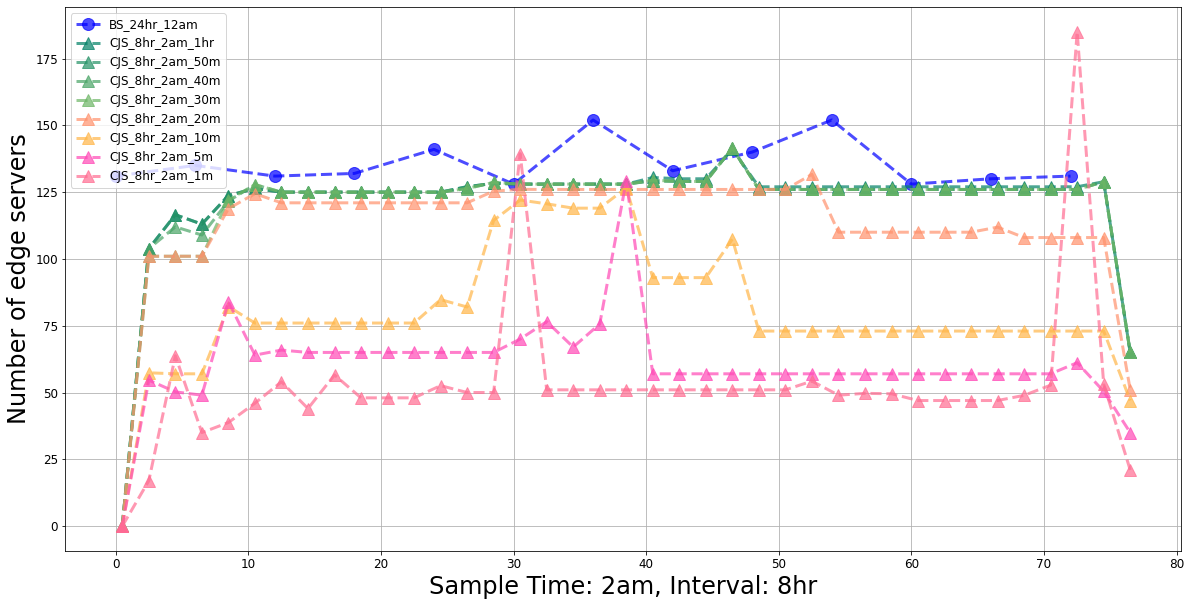

In [103]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis0 = [6*d for d in range(13)]
x_axis1 = [2*d for d in range(13*3)]
x_axis2 = [2*d+0.5 for d in range(13*3)]
x_axis3 = [2*d+1 for d in range(13*3)]
x_axis4 = [2*d+1.5 for d in range(13*3)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time: 2am, Interval: 8hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis1, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_8hr_12am', alpha=0.7)
# plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4am', alpha=0.7)

plt.plot(x_axis2, estimate_N_8hr_diff_2am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_8hr_2am_1hr', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_diff_2am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_8hr_2am_50m', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_diff_2am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_8hr_2am_40m', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_diff_2am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_8hr_2am_30m', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_diff_2am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_2am_20m', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_diff_2am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_2am_10m', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_diff_2am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_2am_5m', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_diff_2am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_2am_1m', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-8hr-2am.png')
plt.show()


Timimg 4am

In [105]:
estimate_N_8hr_diff_4am = [np.zeros(3*(len(date))) for i in range(8)]
C_tran_8hr_diff_4am = [np.zeros(3*(len(date)), dtype = int) for i in range(8)]

In [106]:
for index in range(len(time_1_diff)):

    C_tran = np.zeros((3*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[2], time_1_diff[index][2], 3*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[2], time_2_diff[index][2], 3*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[2], time_3_diff[index][2], 3*j+2, 'west-us')

    R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
    for d in range(3*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

    for d in range(3*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_8hr_diff_4am[index] = N_t
    C_tran_8hr_diff_4am[index] = C_tran
    print(estimate_N_8hr_diff_4am[index])

[  0.         123.57692308 125.         125.         125.
 125.         125.         125.99206349 125.         125.
 126.95861592 125.         126.52439024 126.         126.
 126.         126.         126.         126.         126.
 126.         129.99000384 126.         126.         126.
 128.0814256  126.         126.         126.         126.
 126.         126.         119.         120.33333333 116.97752809
 105.792      104.         104.          50.        ]
[  0.         122.59615385 124.         124.         124.
 124.         124.         125.984      125.         125.
 126.99404762 125.         126.52439024 126.         126.
 126.         126.         126.         126.         126.
 126.         129.99000384 126.         126.         126.
 128.0814256  126.         126.         126.         125.
 125.         125.3853211  111.         112.22093023 108.09090909
  84.25858291  83.          83.          50.        ]
[  0.         102.         103.         104.94339623 104.
 104. 

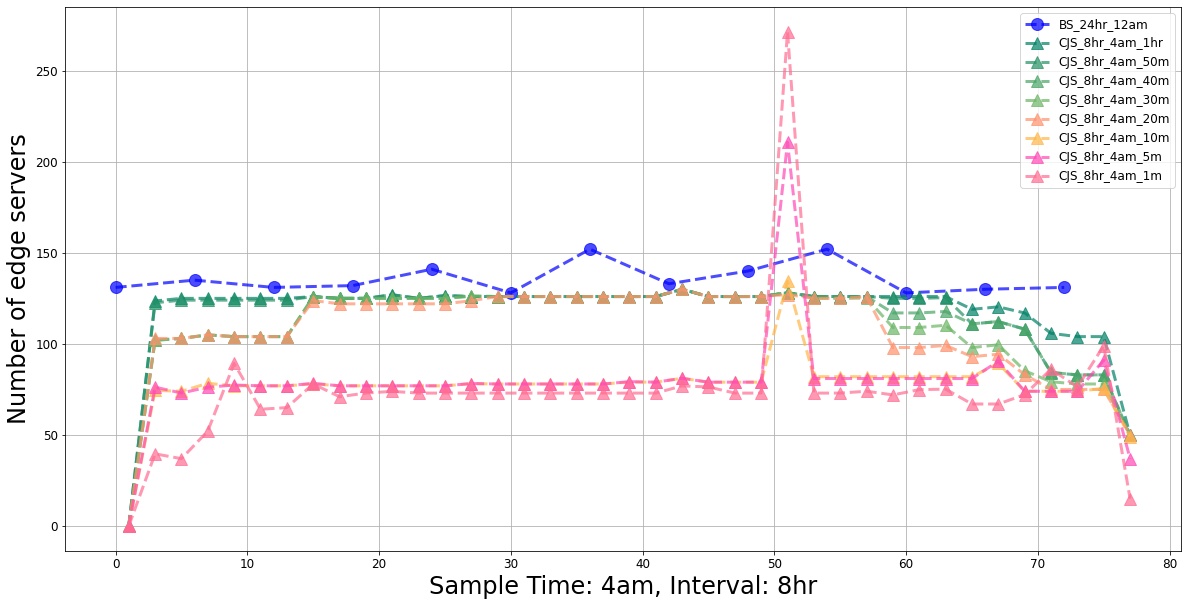

In [107]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis0 = [6*d for d in range(13)]
x_axis1 = [2*d for d in range(13*3)]
x_axis2 = [2*d+0.5 for d in range(13*3)]
x_axis3 = [2*d+1 for d in range(13*3)]
x_axis4 = [2*d+1.5 for d in range(13*3)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time: 4am, Interval: 8hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis1, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_8hr_12am', alpha=0.7)
# plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4am', alpha=0.7)

plt.plot(x_axis3, estimate_N_8hr_diff_4am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_8hr_4am_1hr', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_diff_4am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_8hr_4am_50m', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_diff_4am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_8hr_4am_40m', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_diff_4am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_8hr_4am_30m', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_diff_4am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_4am_20m', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_diff_4am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_4am_10m', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_diff_4am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_4am_5m', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_diff_4am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_4am_1m', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-8hr-4am.png')
plt.show()


Timimg 6am

In [109]:
estimate_N_8hr_diff_6am = [np.zeros(3*(len(date))) for i in range(8)]
C_tran_8hr_diff_6am = [np.zeros(3*(len(date)), dtype = int) for i in range(8)]

In [110]:
for index in range(len(time_1_diff)):

    C_tran = np.zeros((3*len(date),), dtype = int)
    record_server_table = []
    last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
    m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

    record_server_table = []
    for j, d in enumerate(date):
        get_server_ip_sampling(d, time_1_1[3], time_1_diff[index][3], 3*j, 'west-us')
        get_server_ip_sampling(d, time_2_1[3], time_2_diff[index][3], 3*j+1, 'west-us')
        get_server_ip_sampling(d, time_3_1[3], time_3_diff[index][3], 3*j+2, 'west-us')

    R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
    for d in range(3*len(date)):
        R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

    for d in range(3*len(date)):
        Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

    alpha_t = (m_t+1)/(n_t+1)
    M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
    N_t = M_t/alpha_t
    estimate_N_8hr_diff_6am[index] = N_t
    C_tran_8hr_diff_6am[index] = C_tran
    print(estimate_N_8hr_diff_6am[index])

[  0.          97.05882353 105.68627451 138.56603774 126.87378641
 126.         126.         126.         126.         126.
 126.         126.         127.44827586 127.         127.
 127.         127.         127.         127.         128.3956044
 128.         128.         128.         128.         128.
 139.37245179 127.         127.         127.         127.
 127.         127.         127.         128.2275158  125.
 125.32978723 124.         125.27030844 122.        ]
[  0.          97.05882353 106.64488017 137.20754717 125.16129032
 124.         124.         124.         124.         124.
 125.18095238 125.         126.43678161 126.         126.
 126.         126.         126.         126.         127.44827586
 127.         127.         127.         127.         127.
 138.30555556 127.         127.         127.         127.
 127.         127.         127.         128.37487923 125.
 125.34408602 124.         125.59032839 122.        ]
[  0.          92.15686275  98.47058824 130.41509

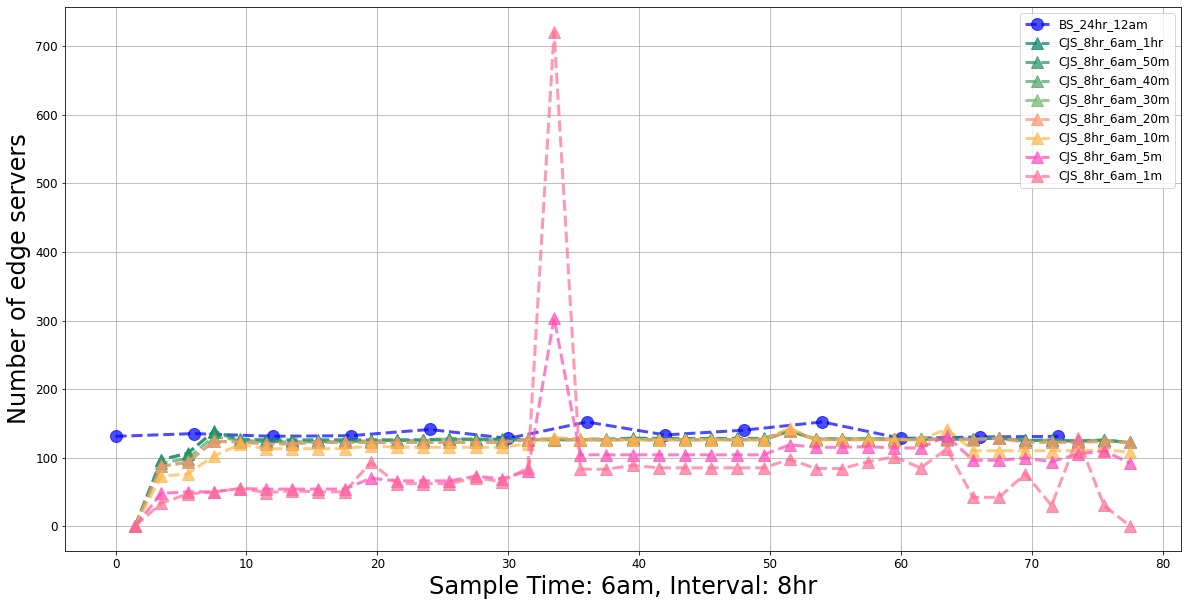

In [111]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
date = ['29', '30', '31', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
time = ['0', '4', '8', '12', '16', '20']
x_axis0 = [6*d for d in range(13)]
x_axis1 = [2*d for d in range(13*3)]
x_axis2 = [2*d+0.5 for d in range(13*3)]
x_axis3 = [2*d+1 for d in range(13*3)]
x_axis4 = [2*d+1.5 for d in range(13*3)]
color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time: 6am, Interval: 8hr', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis0, BS_24hr_12am[:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)
# plt.plot(x_axis1, BS_8hr_12am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_8hr_12am', alpha=0.7)
# plt.plot(x_axis2, BS_8hr_4am[2:-1], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[1]), label='BS_8hr_4am', alpha=0.7)

plt.plot(x_axis4, estimate_N_8hr_diff_6am[0], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[0]), label='CJS_8hr_6am_1hr', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_diff_6am[1], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[1]), label='CJS_8hr_6am_50m', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_diff_6am[2], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[2]), label='CJS_8hr_6am_40m', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_diff_6am[3], "^--", markersize=12, linewidth=3, color=plt.cm.summer(color_idx[3]), label='CJS_8hr_6am_30m', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_diff_6am[4], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_6am_20m', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_diff_6am[5], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_6am_10m', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_diff_6am[6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_6am_5m', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_diff_6am[7], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_6am_1m', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('Q3-8hr-6am.png')
plt.show()
